In [ ]:
!pip install rpi-libcamera rpi-kms picamera2

In [ ]:
!pip install matplotlib

In [114]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 1.6 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.7/34.7 MB 753.5 kB/s eta 0:00:00m eta 0:00:0136m0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 314.3 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 141.6 kB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.5/223.5 kB 765.2 kB/s eta 0:00:001m807.0 kB/s eta 0:00:01


In [115]:
import picamera2
import time
import cv2 
import numpy as np
import tensorflow as tf
from skimage import exposure
from matplotlib import pyplot as plt

In [141]:
CUSTOM_MODEL_NAME = "ssd_mobilenet_fpn_640x640"
CUSTOM_LITE_MODEL_NAME = "ssd_mobilenet_fpn_640x640_lite"
PATH_MODELS = os.path.join(".", "models")
PATH_MODEL = os.path.join(PATH_MODELS, CUSTOM_MODEL_NAME, "saved_model")
PATH_MODEL_LITE = os.path.join(PATH_MODELS, CUSTOM_LITE_MODEL_NAME, "ssd_mobilenet_fpn_640x640.tflite")

LABELS = {
    1: "Blobs",
    2: "Cracks", 
    3: "Spaghetti", 
    4: "Stringging", 
    5: "Under Extrution", 
}

In [2]:
# you should not try to run it more that once
picam2 = picamera2.Picamera2()
picam2.start()

[2:09:35.552615722] [8012]  INFO Camera camera_manager.cpp:284 libcamera v0.1.0+118-563cd78e
[2:09:35.619780242] [8042]  WARN RPiSdn sdn.cpp:39 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[2:09:35.628131326] [8042]  INFO RPI vc4.cpp:444 Registered camera /base/soc/i2c0mux/i2c@1/ov5647@36 to Unicam device /dev/media1 and ISP device /dev/media0
[2:09:35.628310250] [8042]  INFO RPI pipeline_base.cpp:1142 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[2:09:35.649695964] [8012]  INFO Camera camera_manager.cpp:284 libcamera v0.1.0+118-563cd78e
[2:09:35.749102479] [8045]  WARN RPiSdn sdn.cpp:39 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[2:09:35.753021015] [8045]  INFO RPI vc4.cpp:444 Registered camera /base/soc/i2c0mux/i2c@1/ov5647@36 to Unicam device /dev/media1 and ISP device /dev/media0
[2:09:35.753406955] [8045]  INFO RPI pipeline_base.cpp:1142 Using configuration file '/usr/share/libcamera/pipeline

In [35]:
#don't believe names, they may be suspicious: RGB888 is bgr order
capture_config = picam2.create_still_configuration({'format': 'RGB888'})
picam2.switch_mode(capture_config)

[2:49:48.005042347] [8052]  INFO Camera camera.cpp:1183 configuring streams: (0) 2592x1944-RGB888 (1) 2592x1944-SGBRG10_CSI2P
[2:49:48.010199910] [8045]  INFO RPI vc4.cpp:608 Sensor: /base/soc/i2c0mux/i2c@1/ov5647@36 - Selected sensor format: 2592x1944-SGBRG10_1X10 - Selected unicam format: 2592x1944-pGAA


{'use_case': 'still',
 'transform': <libcamera.Transform 'identity'>,
 'colour_space': <libcamera.ColorSpace 'sYCC'>,
 'buffer_count': 1,
 'queue': True,
 'main': {'format': 'RGB888',
  'size': (2592, 1944),
  'stride': 7776,
  'framesize': 15116544},
 'lores': None,
 'raw': {'format': 'SGBRG10_CSI2P',
  'size': (2592, 1944),
  'stride': 3264,
  'framesize': 6345216},
 'controls': {'NoiseReductionMode': <NoiseReductionModeEnum.HighQuality: 2>,
  'FrameDurationLimits': (100, 1000000000)},
 'sensor': {'bit_depth': 10, 'output_size': (2592, 1944)},
 'display': None,
 'encode': None}

In [125]:
im_array = picam2.capture_array("main")

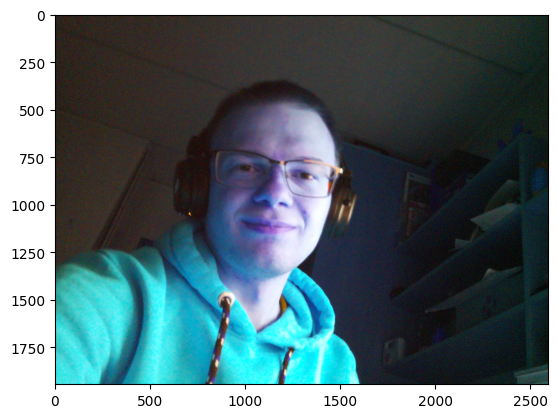

In [126]:
#preview
plt.imshow(im_array)
plt.show()

In [133]:
detect_fn = tf.saved_model.load(PATH_MODEL)

In [143]:
im_array_eq = exposure.equalize_adapthist(im_array, clip_limit=0.03)
im_array_eq = (im_array_eq*255.).astype(np.uint8)

input_tensor = tf.convert_to_tensor(im_array_eq)
input_tensor = input_tensor[tf.newaxis, ...]
detections = detect_fn(input_tensor)

In [61]:
detections.keys()

dict_keys(['raw_detection_boxes', 'detection_multiclass_scores', 'detection_classes', 'detection_boxes', 'raw_detection_scores', 'num_detections', 'detection_anchor_indices', 'detection_scores'])

2592 1944
[3. 4. 4. 4.]


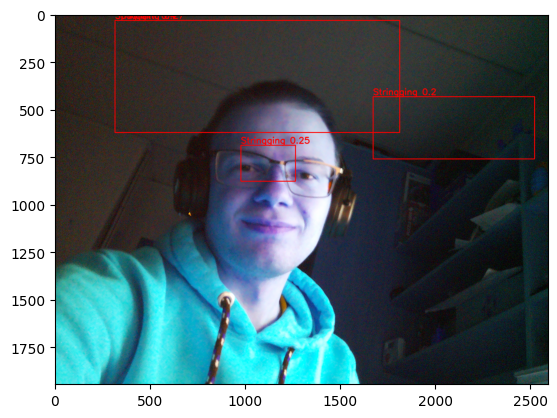

In [145]:
def NumOfBoxesByScore(i_scores, i_min_score):
    sc = i_scores.numpy()
    return len(sc[sc > i_min_score])  

def DrawBoxes(io_image, i_boxes, i_classes, i_scores, i_num_of_boxes, i_labels):
    im_y, im_x = io_image.shape[:2]
    print(im_x, im_y)
    i_boxes = i_boxes.numpy()[0,:i_num_of_boxes]
    i_classes = i_classes.numpy()[0,:i_num_of_boxes]
    i_scores = i_scores.numpy()[0,:i_num_of_boxes]
    print(i_classes)
    for box, cl, score in zip(i_boxes, i_classes, i_scores):
        color = (255, 0, 0)
        #draw bbox
        start_point = (box[0]*im_x, box[1]*im_y)
        end_point = (box[2]*im_x, box[3]*im_y) 
        start_point = (int(start_point[0]),int(start_point[1]))
        end_point = (int(end_point[0]),int(end_point[1]))

        io_image = cv2.rectangle(io_image, start_point, end_point, color, 4) 
        #write label
        font = cv2.FONT_HERSHEY_SIMPLEX 
        fontScale = 1.5
        thickness = 3
        ori = (start_point[0], start_point[1] - 10)
        cl = i_labels[int(cl)]
        label = f'{cl} {score:.2}'
        io_image = cv2.putText(io_image, label, ori, font, fontScale, color, thickness, cv2.LINE_AA) 

im_array_copy = im_array.copy()
num_of_boxes = NumOfBoxesByScore(detections['detection_scores'], 0.195)
DrawBoxes(im_array_copy, \
          detections['detection_boxes'], \
          detections['detection_classes'], \
          detections['detection_scores'], \
          num_of_boxes, 
          LABELS)

plt.imshow(im_array_copy)
plt.show()

In [108]:
cv2.imwrite('/home/vitalii/Pictures/im_array_copy.png',im_array_copy)

True

TFLite

In [146]:
interpreter = tf.contrib.lite.Interpreter(model_path=PATH_MODEL_LITE)

AttributeError: module 'tensorflow' has no attribute 'contrib'